In [2]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from pytz import timezone

In [3]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = 32
NUM_CLASSES = 10

In [4]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            _, probabilities = model(images)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [5]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [6]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits, _ = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [7]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits, _ = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [8]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):

        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [9]:
class LeNet5(nn.Module):

    def __init__(self, num_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Dropout(p=0.5),  # 드롭아웃 추가
            nn.Linear(in_features=84, out_features=num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15763571.79it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494756.53it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1812077.44it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9568321.83it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Train dataset size: 60000
Validation dataset size: 10000


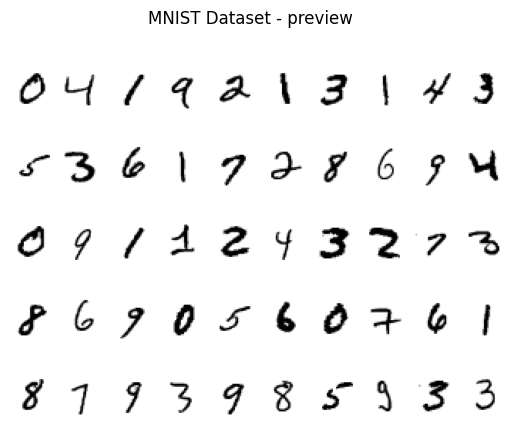

In [10]:
# transforms 정의하기
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# 데이터셋 다운로드 및 생성
train_dataset = datasets.MNIST(
    root="mnist_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.MNIST(root="mnist_data", train=False, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 불러온 MNIST 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    plt.imshow(train_dataset.data[index], cmap="gray_r")
fig.suptitle("MNIST Dataset - preview")

# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")  # Train dataset size: 60000
print(
    f"Validation dataset size: {len(valid_dataset)}"
)  # Validation dataset size: 10000

00:40:35 ---  Epoch: 0	Train loss: 2.2943	Valid loss: 2.2750	Train accuracy: 24.79	Valid accuracy: 24.95
00:41:03 ---  Epoch: 1	Train loss: 2.2410	Valid loss: 2.1776	Train accuracy: 53.46	Valid accuracy: 54.84
00:41:30 ---  Epoch: 2	Train loss: 2.0097	Valid loss: 1.7243	Train accuracy: 61.88	Valid accuracy: 62.92
00:41:56 ---  Epoch: 3	Train loss: 1.4469	Valid loss: 1.1303	Train accuracy: 72.36	Valid accuracy: 73.25
00:42:24 ---  Epoch: 4	Train loss: 1.0143	Valid loss: 0.8119	Train accuracy: 79.77	Valid accuracy: 80.52
00:42:51 ---  Epoch: 5	Train loss: 0.7908	Valid loss: 0.6479	Train accuracy: 83.19	Valid accuracy: 83.80
00:43:17 ---  Epoch: 6	Train loss: 0.6650	Valid loss: 0.5489	Train accuracy: 85.30	Valid accuracy: 85.80
00:43:44 ---  Epoch: 7	Train loss: 0.5857	Valid loss: 0.4842	Train accuracy: 86.61	Valid accuracy: 87.37
00:44:11 ---  Epoch: 8	Train loss: 0.5292	Valid loss: 0.4380	Train accuracy: 87.53	Valid accuracy: 88.37
00:44:38 ---  Epoch: 9	Train loss: 0.4905	Valid loss: 0

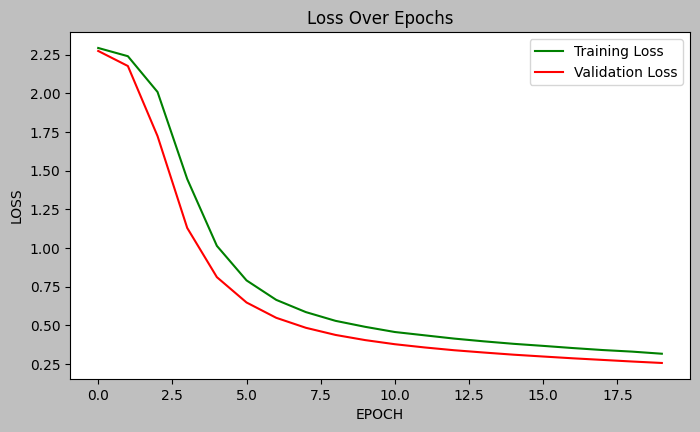

In [11]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)

00:49:35 ---  Epoch: 0	Train loss: 0.2794	Valid loss: 0.1047	Train accuracy: 96.96	Valid accuracy: 96.71
00:50:02 ---  Epoch: 1	Train loss: 0.1035	Valid loss: 0.0642	Train accuracy: 98.13	Valid accuracy: 97.93
00:50:30 ---  Epoch: 2	Train loss: 0.0744	Valid loss: 0.0538	Train accuracy: 98.56	Valid accuracy: 98.30
00:50:57 ---  Epoch: 3	Train loss: 0.0647	Valid loss: 0.0490	Train accuracy: 98.76	Valid accuracy: 98.47
00:51:25 ---  Epoch: 4	Train loss: 0.0540	Valid loss: 0.0432	Train accuracy: 99.08	Valid accuracy: 98.56
00:51:52 ---  Epoch: 5	Train loss: 0.0474	Valid loss: 0.0525	Train accuracy: 99.09	Valid accuracy: 98.33
00:52:19 ---  Epoch: 6	Train loss: 0.0441	Valid loss: 0.0579	Train accuracy: 98.98	Valid accuracy: 98.42
00:52:47 ---  Epoch: 7	Train loss: 0.0380	Valid loss: 0.0497	Train accuracy: 99.24	Valid accuracy: 98.58
00:53:15 ---  Epoch: 8	Train loss: 0.0379	Valid loss: 0.0451	Train accuracy: 99.43	Valid accuracy: 98.63
00:53:42 ---  Epoch: 9	Train loss: 0.0332	Valid loss: 0

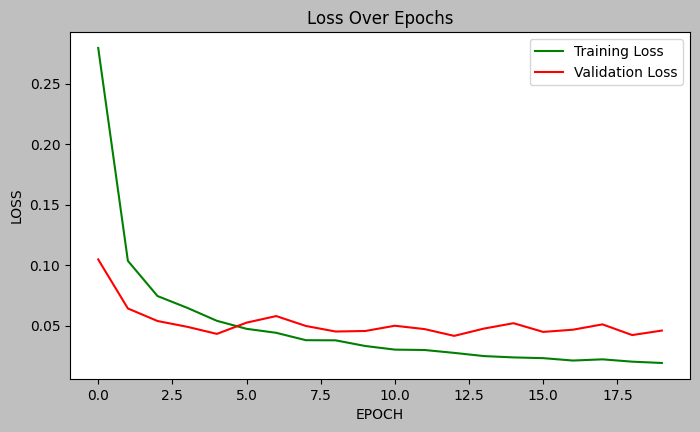

In [12]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)